# Target 선정

- 이 데이터셋의 Metric은 35개의 Target과 예측값과의 spearman coefficient이 평균입니다.

- 수많은 ML 모델을 만들어서 깨닭은 사실은 입력데이터들로 예측이 잘 되는 케이스도 있지만 그렇지 않은 케이스도 있습니다.

- 예측이 안 되는 것들을 같이 학습을 시킬 경우에는 오히려 역효과가 크게 됩니다. 

- R2를 구해서 예측이 잘되는 것을 위주로 학습을 시킵니다.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-05-06 13:18:05.211971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746537485.231106   15288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746537485.236874   15288 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [2]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = (np.array(train_images[slide_name]) * 255).astype('uint8')
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
            if slide_name == 'S_1':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 50,
                    y = lambda x: x['y'] - 50,
                )
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = (np.array(test_images[sample]) * 255).astype('uint8')
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(images)
    df_spots = pd.concat(spots).reset_index(drop = True)
    with tf.device('/CPU:0'):
        images_test = tf.constant(images_test)
    df_spots_test = pd.concat(spots_test).reset_index(drop = True)
    return images, df_spots, images_test, df_spots_test

def make_img_proc_info(df, img_width, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['left'] + img_width,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['top'] + img_height,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[targets_l])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.cast(tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    ), tf.float32) / 255.0

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]
n_components = 35
targets_l = ['C{}_l'.format(i + 1) for i in range(n_components)]
df_spots= df_spots.join(
    np.log(df_spots[targets]).rename(columns = lambda x: x + '_l')
)

I0000 00:00:1746537489.923115   15288 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


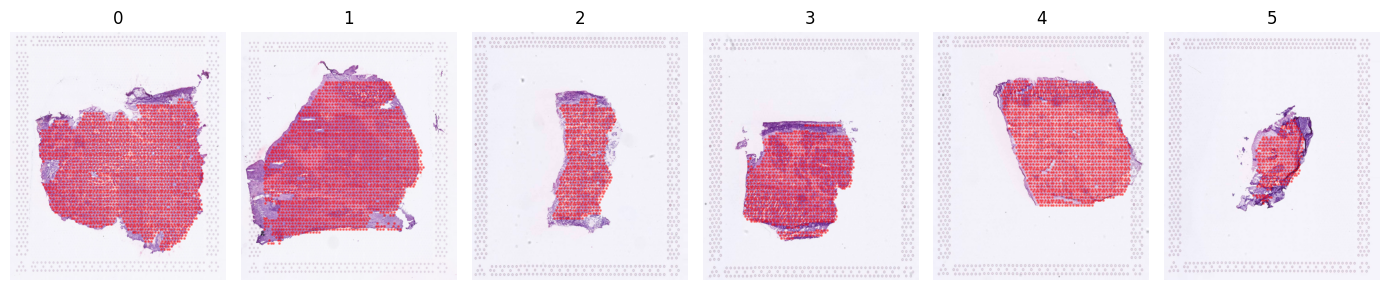

In [3]:
fig, ax = plt.subplots(1, 6, figsize=(14, 3))
for i, slide_name in enumerate(range(6)):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]

    ax[i].imshow(image, aspect="auto")
    ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax[i].set_title(slide_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
df_spots['slide'].unique()

array([0, 1, 2, 3, 4, 5])

In [26]:
df_corr = df_spots[targets_l].corr(method = 'spearman')
df_dist = 1 - df_corr.abs()

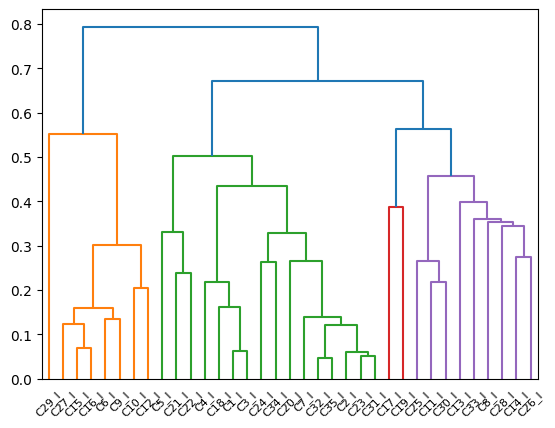

In [30]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
Z = hierarchy.linkage(squareform(df_dist), method = 'average')
hierarchy.dendrogram(Z, labels = df_dist.columns)
plt.show()

In [31]:
df_spots[targets_l].std().sort_values(ascending=False)

C30_l    4.259399
C4_l     4.053365
C10_l    4.039928
C27_l    3.940798
C9_l     3.890528
C11_l    3.759918
C6_l     3.727915
C22_l    3.664482
C5_l     3.557018
C17_l    3.444126
C25_l    3.262344
C29_l    3.242636
C33_l    3.237917
C19_l    3.193447
C21_l    3.094334
C28_l    3.084750
C26_l    2.981018
C13_l    2.946209
C15_l    2.945959
C34_l    2.806590
C24_l    2.794466
C16_l    2.671740
C8_l     2.664255
C1_l     2.572806
C3_l     2.264935
C14_l    2.135892
C18_l    1.989418
C12_l    1.891744
C20_l    1.839499
C35_l    1.659330
C7_l     1.654106
C32_l    1.486195
C31_l    1.480825
C23_l    1.410427
C2_l     1.257504
dtype: float64

In [4]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    enet_, _ = joblib.load('model/ae_encoder_b0_obj.joblib')
    enet = tf.keras.applications.EfficientNetB0(
        include_top = False, 
        weights = None,
        input_shape = input_shape,
        pooling = 'avg'
    )
    enet.set_weights(enet_)
    enet.trainable = False
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(256, activation = 'swish', kernel_initializer = 'HeUniform')
    x = d1(x)
    d2 = tf.keras.layers.Dense(len(targets_l))
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

def reconstruct_model(layers):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    x = layers[0](inputs, training = True)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = layers[1](x)
    outputs = layers[2](x)
    m = tf.keras.models.Model(inputs, outputs)
    return m

def train_model(
        m, train_idx, valid_idx, learning_rate, 
        target_proc = FunctionTransformer(lambda x: x, lambda x: x), 
        batch_size = 32, epochs = 20, step = ''
    ):

    ds_cv_train = create_tf_ds(
        df_spots.iloc[train_idx].pipe(
            lambda x: pd.concat([
                x, x.sample(n = batch_size - (len(x) % batch_size))
            ])
        )
    ).shuffle(5000).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).map(
        lambda X, Y: (data_augmentation(X), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

    ds_cv_prd = create_tf_ds(
        df_spots.iloc[train_idx]
    ).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    if valid_idx is not None:
        ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
            lambda X, Y: (proc_images(X, images), Y)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    else:
        ds_valid = None
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=300 * epochs,
        alpha=0.1
    )
    m.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        metrics = [tf.keras.metrics.MeanSquaredError()]
    )

    df_true_train = df_spots.iloc[train_idx][targets_l]
    if valid_idx is not None:
        df_true = df_spots.iloc[valid_idx][targets_l]
    else:
        df_true = None
    progress_bar = tqdm(total = epochs, desc=step)
    scores_train, scores_valid = list(), list()
    mse_train, mse_valid = list(), list()
    df_prd = None
    for i in range(epochs):
        hist = m.fit(ds_cv_train, epochs = 1, verbose = 0)
        df_prd = pd.DataFrame(
            target_proc.inverse_transform(m.predict(ds_cv_prd, verbose = 0)), 
            index = df_true_train.index, columns = targets_l
        )
        scores_train.append(
            df_true_train.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
        )
        mse_train.append(
            df_true_train.apply(lambda x: mean_squared_error(x, df_prd[x.name]), axis=0).mean()
        )
        metric = "train coef: {:.4f}, train mse: {:.4f}".format(scores_train[-1], mse_train[-1])
        if valid_idx is not None:
            df_prd = pd.DataFrame(
                target_proc.inverse_transform(m.predict(ds_valid, verbose = 0)), 
                index = df_true.index, columns = targets_l
            )
            scores_valid.append(
                df_true.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
            )
            mse_valid.append(
                df_true.apply(lambda x: mean_squared_error(x, df_prd[x.name]), axis=0).mean()
            )
            metric = metric + ", valid coef: {:.4f}, valid mse: {:.4f}".format(scores_valid[-1], mse_valid[-1])
        progress_bar.set_postfix_str(metric)
        progress_bar.update(1)
    progress_bar.close()
    return (scores_train, scores_valid), df_prd

# Validation

In [5]:
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [31]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-4, 
        batch_size = 32, epochs = 10, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/10 [00:00<?, ?it/s]

train 1:   0%|          | 0/10 [00:00<?, ?it/s]

train 2:   0%|          | 0/10 [00:00<?, ?it/s]

train 3:   0%|          | 0/10 [00:00<?, ?it/s]

train 4:   0%|          | 0/10 [00:00<?, ?it/s]

train 5:   0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
from scipy.stats import spearmanr
df_oof[targets_l].groupby(df_spots['slide']).apply(
    lambda x: x.apply(lambda x: spearmanr(df_spots.loc[x.name, targets_l], x)[0], axis = 1).mean()
)

slide
0    0.360893
1    0.556059
2    0.573930
3    0.449498
4    0.296081
5    0.553398
dtype: float64

In [36]:
from scipy.stats import spearmanr
df_oof[targets_l].apply(
    lambda x: spearmanr(df_spots.loc[x.name, targets_l], x)[0], axis=1
).mean()

0.43870446971839605

In [43]:
df_spots

,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C34_l,C35_l,left,right,top,bottom,lpad,rpad,tpad,bpad
0,1504,1247,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,-6.521295,-2.994601,1392,1616,1135,1359,0,0,0,0
1,412,1452,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,-5.491336,-3.005956,300,524,1340,1564,0,0,0,0
2,1438,1498,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,-7.764301,-4.176787,1326,1550,1386,1610,0,0,0,0
3,1675,1132,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,-6.295450,-2.153971,1563,1787,1020,1244,0,0,0,0
4,531,1063,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,-9.146751,-4.334929,419,643,951,1175,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8344,1173,842,0.008615,0.052352,0.009905,0.003060,5.230128,0.000176,0.040653,0.000188,...,-8.126177,-4.527064,1061,1285,730,954,0,0,0,0
8345,1237,775,0.034781,0.028511,0.031475,0.001812,1.121948,0.000052,0.008572,0.001044,...,-9.084836,-5.493055,1125,1349,663,887,0,0,0,0
8346,903,953,0.000515,0.011848,0.001639,0.000039,0.104526,0.000024,0.001327,0.000014,...,-10.952828,-7.384148,791,1015,841,1065,0,0,0,0
8347,954,1310,0.009845,0.076963,0.013963,0.001142,5.819259,0.000598,0.073316,0.000391,...,-7.735852,-3.979451,842,1066,1198,1422,0,0,0,0


In [14]:
#df_oof, scores = joblib.load('result/check_r2.joblib')

In [33]:
pd.Series(
    {
        i: pd.concat([
            df_spots.groupby('slide')[[i, 'slide']].apply(
                lambda x: ((x[i] - df_spots.loc[df_spots['slide'] != x.name, i].mean()) ** 2).mean()
            ).rename('SST'),
            df_oof.groupby(df_spots['slide'])[i].apply(
                lambda x: ((x - df_spots.loc[x.index, i]) ** 2).mean()
            ).rename('SSE')
        ], axis=1).pipe(
            lambda x: 1 - x['SSE'] / x['SST']
        ).mean()
        for i in targets_l
    }
).sort_values(ascending = False)

C22_l    0.104785
C21_l    0.090723
C5_l     0.084365
C31_l    0.065337
C19_l    0.043779
C32_l    0.041691
C23_l    0.031734
C35_l    0.026277
C2_l     0.023476
C7_l     0.020535
C18_l    0.018189
C34_l    0.017841
C17_l    0.013889
C20_l    0.005445
C24_l   -0.016459
C33_l   -0.056424
C25_l   -0.064431
C13_l   -0.081289
C3_l    -0.085290
C26_l   -0.099065
C16_l   -0.103312
C29_l   -0.108543
C14_l   -0.112474
C30_l   -0.121799
C1_l    -0.137456
C28_l   -0.144088
C15_l   -0.144746
C9_l    -0.147066
C8_l    -0.153983
C10_l   -0.179099
C11_l   -0.188760
C6_l    -0.188939
C4_l    -0.201511
C12_l   -0.211030
C27_l   -0.213669
dtype: float64

In [23]:
df_mean = list()
for i in df_spots['slide'].unique():
    df_mean.append(
        df_spots.loc[df_spots['slide'] != i, targets_l].mean().rename(i)
    )
df_mean = pd.concat(df_mean, axis = 1)
df_mean.head()

,0,1,2,3,4,5
C1_l,-1.847055,-3.273974,-2.363738,-2.066767,-1.980283,-2.206597
C2_l,-2.651404,-2.733081,-2.711964,-2.783948,-2.795998,-2.752525
C3_l,-1.973068,-3.209727,-2.390238,-2.151174,-2.014289,-2.265878
C4_l,-4.665119,-6.529190,-5.169444,-4.665417,-4.173738,-4.872292
C5_l,-2.834589,-3.018223,-2.601074,-2.664856,-1.437695,-2.608572


In [26]:
df_pred_sel = df_spots['slide'].apply(lambda x: df_mean[x])
df_spots[targets_l].apply(lambda x: spearmanr(x, df_pred_sel.loc[x.name])[0], axis= 1).mean()

0.4695411282251552

In [35]:
df_pred_sel = df_spots['slide'].apply(lambda x: df_mean[x]).assign(
    C22_l = df_oof['C22_l'],
    C21_l = df_oof['C21_l'],
    C5_l = df_oof['C5_l'],
)
df_spots[targets_l].apply(lambda x: spearmanr(x, df_pred_sel.loc[x.name])[0], axis= 1).mean()

0.4725681433191315

In [45]:
joblib.dump((df_oof, scores), 'result/check_r2.joblib')

['result/check_r2.joblib']

In [5]:
from sklearn.metrics import r2_score
def create_tf_ds_1(df, t = None):
    if t is not None:
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[t])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })
    
def create_model_1(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    enet_, _ = joblib.load('model/ae_encoder_b0_obj.joblib')
    enet = tf.keras.applications.EfficientNetB0(
        include_top = False, 
        weights = None,
        input_shape = input_shape,
        pooling = 'avg'
    )
    enet.set_weights(enet_)
    enet.trainable = False
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(256, activation = 'swish', kernel_initializer = 'HeUniform')
    x = d1(x)
    d2 = tf.keras.layers.Dense(1)
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

def train_model_1(
        m, t, train_idx, valid_idx, learning_rate, batch_size = 32, epochs = 20, step = ''
    ):
    tf.keras.backend.clear_session()
    ds_cv_train = create_tf_ds_1(
        df_spots.iloc[train_idx].pipe(
            lambda x: pd.concat([
                x, x.sample(n = batch_size - (len(x) % batch_size))
            ])
        ), t
    ).shuffle(5000).map(
        lambda X, y: (proc_images(X, images), y)
    ).map(
        lambda X, y: (data_augmentation(X), y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

    ds_cv_prd = create_tf_ds_1(
        df_spots.iloc[train_idx], t
    ).map(
        lambda X, y: (proc_images(X, images), y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    if valid_idx is not None:
        ds_valid = create_tf_ds_1(df_spots.iloc[valid_idx], t).map(
            lambda X, y: (proc_images(X, images), y)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    else:
        ds_valid = None
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=5000,
        alpha=0.1
    )
    m.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    )

    s_true_train = df_spots.iloc[train_idx][t]
    if valid_idx is not None:
        s_true = df_spots.iloc[valid_idx][t]
    else:
        s_true = None
    progress_bar = tqdm(total = epochs, desc=step)
    scores_train, scores_valid = list(), list()
    mse_train, mse_valid = list(), list()
    s_prd = None
    for i in range(epochs):
        hist = m.fit(ds_cv_train, epochs = 1, verbose = 0)
        s_prd = m.predict(ds_cv_prd, verbose = 0)
        scores_train.append(r2_score(s_true_train, s_prd))
        mse_train.append(mean_squared_error(s_true_train, s_prd))
        metric = "train r2: {:.4f}, train mse: {:.4f}".format(scores_train[-1], mse_train[-1])
        if valid_idx is not None:
            s_prd = pd.Series(m.predict(ds_valid, verbose = 0)[:, 0], index = s_true.index, name = t)
            mse_valid.append(mean_squared_error(s_true, s_prd))
            scores_valid.append(1 - mse_valid[-1] / ((s_true - s_true_train.mean()) ** 2).mean())
            metric = metric + ", valid r2: {:.4f}, valid mse: {:.4f}".format(scores_valid[-1], mse_valid[-1])
        progress_bar.set_postfix_str(metric)
        progress_bar.update(1)
    progress_bar.close()
    return (scores_train, scores_valid), s_prd

In [6]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
t = 'C22_l'
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[t], groups = df_spots['slide'])
):
    m, layers = create_model_1(img_width, img_height)
    score_1, s_prd = train_model_1(
        m, t, train_idx, valid_idx, learning_rate = 1e-4, 
        batch_size = 32, epochs = 15, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(s_prd)
s_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/15 [00:00<?, ?it/s]

I0000 00:00:1746534326.824499   10820 service.cc:148] XLA service 0x7f910814b990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746534326.824527   10820 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746534327.761185   10820 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746534337.310730   10820 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


train 1:   0%|          | 0/15 [00:00<?, ?it/s]

train 2:   0%|          | 0/15 [00:00<?, ?it/s]

train 3:   0%|          | 0/15 [00:00<?, ?it/s]

train 4:   0%|          | 0/15 [00:00<?, ?it/s]

train 5:   0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
np.mean([i[1][-1] for i in scores])

0.11474752709818602

In [37]:
joblib.dump(s_oof, 'result/check_r2_C22_l.joblib')

['result/check_r2_C22_l.joblib']

# Stratified KFold

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 123, shuffle = True)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    skf.split(df_spots[['x', 'y']], df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-4, 
        batch_size = 32, epochs = 20, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

train 0:   0%|          | 0/20 [00:00<?, ?it/s]

I0000 00:00:1746537578.272948   15336 service.cc:148] XLA service 0x7f450014d900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746537578.272991   15336 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746537579.387187   15336 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746537588.624547   15336 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


train 1:   0%|          | 0/20 [00:00<?, ?it/s]

train 2:   0%|          | 0/20 [00:00<?, ?it/s]

train 3:   0%|          | 0/20 [00:00<?, ?it/s]

train 4:   0%|          | 0/20 [00:00<?, ?it/s]